# 3D reconstruction
---

In [1]:
import matplotlib.pyplot as plt

from tqdm                 import tqdm
from astropy              import units

from p3droslo.observation import DataCube
from p3droslo.utils       import get_distance_from_Simbad, convert_angular_to_spatial

In [2]:
distance = get_distance_from_Simbad('IK Tau')

Using the parallax distance.


In [3]:
file     = '/STER/frederikd/Deprojection/data/observations/IKTau_CO3-2.fits'
datacube = DataCube(file)

In [6]:
datacube.plot_channel_maps()

interactive(children=(IntSlider(value=30, description='f', max=60), Output()), _dom_classes=('widget-interact'…

<function p3droslo.observation.DataCube.plot_channel_maps.<locals>.plot(f)>

In [244]:
angle_x = abs(datacube.npix_x * datacube.pixsize_x)
angle_y = abs(datacube.npix_y * datacube.pixsize_y)

size_x = 1.0 * units.m #convert_angular_to_spatial(angle_x, distance)
size_y = 1.0 * units.m #convert_angular_to_spatial(angle_y, distance)
size_z = max(size_x, size_y)

size_x = size_x.to(units.m).value
size_y = size_y.to(units.m).value
size_z = size_z.to(units.m).value

box_shape = (100, 100, 100)

In [245]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.optim      import Adam, LBFGS

In [246]:
# Model Hyperparameters
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [275]:
class TensorModel():
    """
    A (deterministic) model in which every variable is represented by a 3-tensor.
    """
    
    def __init__(self, var_keys, box_sizes, box_shape):
        """
        Initialise a Tensor model.
        """
        # Set sizes of the model box.
        self.box_sizes = box_sizes
        # Set shape of Tensor variables. 
        self.box_shape = box_shape
        # Initialise variables with random Tensor with appropriate shape 
        self.vars = {v:torch.rand(self.box_shape, requires_grad=True) for v in var_keys}
        
    def __getitem__(self, var_key):
        """
        Getter for variables (vars). Allows the use of [] operators.
        """
        return self.vars[var_key]
    
    def __setitem__(self, var_key, value):
        """
        Setter for variables (vars). Allows the use of [] operators.
        """
        self.vars[var_key] = value
        
    def parameters(self):
        """
        Return a list of all variables in the TensorModel.
        """
        return list(model.vars.values())
    
    def dx(self, i):
        """
        Return the size of a model element.
        """
        return self.box_sizes[i] / self.box_shape[i]
    
    def integrate(self, var, axis=2):
        """
        Integrate a variable along an axis of the model box.
        """
        return torch.cumsum(self.dx(axis)*var, dim=axis)
    
    
    def integrate_out(self, var, axis=2):
        """
        Integrate a variable out along an axis of the model box.
        """
        return torch.sum(self.dx(axis)*var, dim=axis)

    def create_image(self, eta, chi, axis=2):
        """
        Formal solution of the transfer equation (discretised as TensorModel)
        """
        tau = self.integrate    (chi,                 axis=axis)
        img = self.integrate_out(eta*torch.exp(-tau), axis=axis)
        return img
    
    
model = TensorModel(
    var_keys  = ['emissivity','opacity'],
    box_sizes = (size_x, size_y, size_z),
    box_shape = box_shape
)

In [276]:
def interpolate(inp, size, mode='nearest'):
    # Reshape to add batch ids and channels
    # (Because that is what torch.nn.functional.interpolate expects.)
    res = inp.view((1, 1) + inp.size())
    # Interpolate
    res = torch.nn.functional.interpolate(res, size=size, mode=mode)
    # Return without batch ids and channels
    return res.view(size)

In [277]:
shape_f = 1

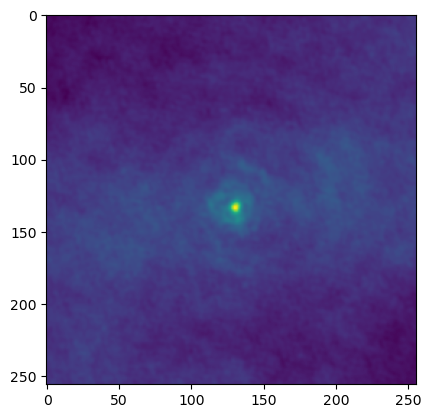

In [278]:
plt.imshow(datacube.img[31])

In [279]:
obs = torch.Tensor(datacube.img)
# obs = interpolate(obs, size=(obs.size(0), box_shape[0], box_shape[1]), mode='trilinear')
obs = interpolate(obs, size=(1, box_shape[0], box_shape[1]), mode='trilinear')

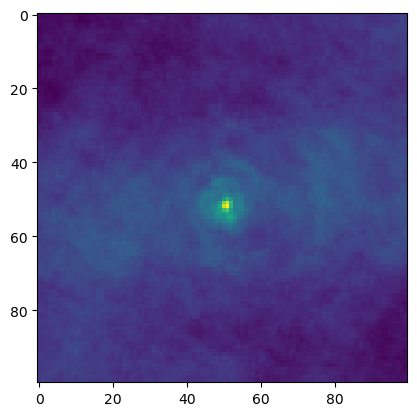

In [280]:
plt.imshow(obs[0])

In [281]:
model = TensorModel(
    var_keys  = ['emissivity','opacity'],
    box_sizes = (size_x, size_y, size_z),
    box_shape = box_shape
)

# model['opacity'].data *= 1.0e-10

In [282]:
N_epochs = 100
lr       = 1.0e-1

optimizer = Adam(model.parameters(), lr=lr)

In [283]:
losses = np.zeros(N_epochs)

for i in tqdm(range(N_epochs)):
    
    chi = model['opacity']
    eta = model['emissivity']
    img = model.create_image(eta, chi, axis=2)
    
    loss_func = nn.functional.mse_loss(img, obs[0])
    losses[i] = loss_func.item()
    
    optimizer.zero_grad()
    loss_func.backward ()
    optimizer.step     ()

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 106.03it/s]


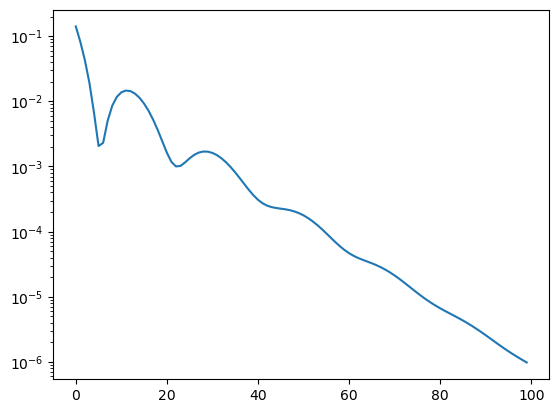

In [284]:
plt.plot(losses)
plt.yscale('log')

In [267]:
import numpy as np

np.zeros(120)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [257]:
tau.data.min()

tensor(0.0005)

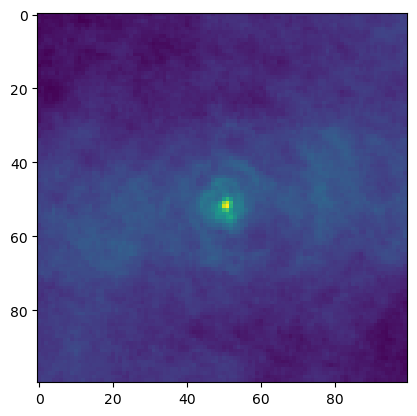

In [258]:
plt.imshow(img.data)

In [260]:
from ipywidgets import interactive

In [263]:
def plot(i):
    plt.imshow(chi.data[:,:,i])

interactive(plot, i=(0,eta.data.shape[2]-1))  

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

In [259]:
class Data(Dataset):
    def __init__(self, datacube):
        self.datacube = datacube
    
    def __len__(self):
        return self.datacube.img.size

    def __getitem__(self, idx):
        return self.datacube.img[idx]